<hr style="border:2px solid #0176DE"> </hr>
<center><h1 style="color:#173F8A;"> EMI 2024 - CMM Chile</h1></center>
<hr style="border:2px solid #0176DE"> </hr>
<h3 style="color:#173F8A;text-align:right;"> Profesores: &nbsp;Nicolás Barnafi<br>Manuel A. Sanchez<br></h3>

<h3 style="color:#03122E;text-align:right;"> 
    Centro de Modelamiento Matemático <br> 
    Instituto de Ingeniería Matemática y Computacional - IMC UC<br>  
</h3>

<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Módulo 1: Introducción</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC:
Primaria: 
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->

- The motivation

  3D simulations, HPC

- The actual motivation

  Upscale simulations, black-box never works

# The only requirement: Weak formulations

$$ -\Delta u = f \quad \Leftrightarrow \quad \int \nabla u \cdot \nabla v\,dx = \int f v\,dx \quad \forall v \in V_0$$

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import scipy.sparse as sp
from scipy.sparse.linalg import splu
from time import perf_counter
import matplotlib.pylab as plt

# Define geometry
shape = Rectangle(2,0.41).Face()
shape.edges.name="wall"
shape.edges.Min(X).name="inlet"
shape.edges.Max(X).name="outlet"
geo = OCCGeometry(shape, dim=2)
Draw (shape);

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [2]:
# Approximate geometry with a mesh
mesh = Mesh(geo.GenerateMesh(maxh=0.1))
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [3]:
# Functional space, trial and test functions
V = H1(mesh, order=2, dirichlet="wall|inlet|cyl")
u, v = V.TnT()

# Problem definition
form = InnerProduct(Grad(u), Grad(v))*dx
a = BilinearForm(form).Assemble()
f = LinearForm(v*dx).Assemble()
gf = GridFunction(V) # Solution vector

# Boundary condition
uin = CF(1.5*4*y*(0.41-y)/(0.41*0.41))
gf.Set(uin, definedon=mesh.Boundaries("inlet"))

# Solution with sparse LU factorization
res = f.vec -a.mat * gf.vec
inv = a.mat.Inverse(freedofs=V.FreeDofs(), inverse="umfpack")
gf.vec.data += inv * res
Draw(gf)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [4]:
# Now we compute the nonzeros in the LU factorization
rows,cols,vals = a.mat.COO()
nnzA = len(vals)
A = sp.csr_matrix((vals,(rows,cols))) # NGSolve mat to scipy.sparse
LU = splu(A)
nnzs = LU.L.nnz + LU.U.nnz
print("Number of non-zeros of A:", nnzA)
print("Number of non-zeros of L+U:", nnzs)
print("Ratio of non-zeros:", len(vals)/nnzs)

Number of non-zeros of A: 4103
Number of non-zeros of L+U: 13404
Ratio of non-zeros: 0.3061026559236049


/usr/lib/python3/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


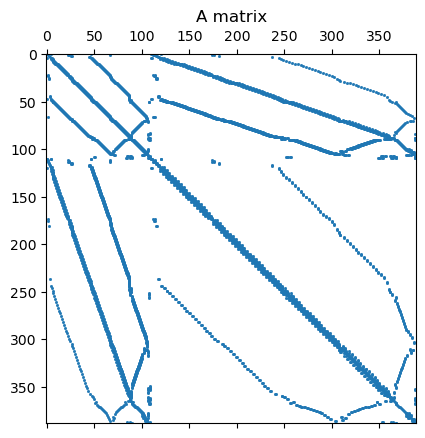

In [5]:
# Spy arrays
plt.spy(A, markersize=1.0)
plt.title("A matrix")
plt.show()

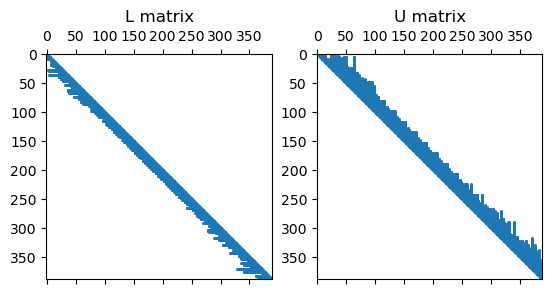

In [6]:
plt.subplot(1,2,1)
plt.spy(LU.L, markersize=1)
plt.title("L matrix")
plt.subplot(1,2,2)
plt.spy(LU.U, markersize=1)
plt.title("U matrix")
plt.show()

In [7]:
def computeNonzeros(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = H1(mesh, order=2, dirichlet="wall|inlet|cyl")
    u, v = V.TnT()
    form = InnerProduct(Grad(u), Grad(v))*dx
    a = BilinearForm(form).Assemble()
    rows,cols,vals = a.mat.COO()
    nnzA = len(vals)
    
    A = sp.csr_matrix((vals,(rows,cols)))
    LU= splu(A)
    nnzs = LU.L.nnz + LU.U.nnz
    print("Number of non-zeros of A:", nnzA, "(in {:1.3f} Mb)".format(convertToMb(nnzA)))
    print("Number of non-zeros of L+U:", nnzs, "(in {:1.3f} Mb)".format(convertToMb(nnzs)))
    print("Ratio A.nnz / LU.nnz:", nnzA/nnzs)
    return nnzA, nnzs

def convertToMb(nval):
    # 8 bytes per val 
    return nval * 8 * 1e-6

In [8]:
for h in [0.1, 0.05, 0.01, 0.005]:
    print(f"========= Using h={h:1.3f}")
    nnza, nnzlu = computeNonzeros(h)

========= Using h=0.100
Number of non-zeros of A: 4103 (in 0.033 Mb)
Number of non-zeros of L+U: 13404 (in 0.107 Mb)
Ratio A.nnz / LU.nnz: 0.3061026559236049
========= Using h=0.050
Number of non-zeros of A: 17681 (in 0.141 Mb)
Number of non-zeros of L+U: 113710 (in 0.910 Mb)
Ratio A.nnz / LU.nnz: 0.15549204115733006
========= Using h=0.010
Number of non-zeros of A: 435939 (in 3.488 Mb)
Number of non-zeros of L+U: 9348652 (in 74.789 Mb)
Ratio A.nnz / LU.nnz: 0.04663121485322162
========= Using h=0.005
Number of non-zeros of A: 1737827 (in 13.903 Mb)
Number of non-zeros of L+U: 55068366 (in 440.547 Mb)
Ratio A.nnz / LU.nnz: 0.031557627840274036


In [9]:
from time import perf_counter
def solveDirect(maxh, p):
    # Functional space, trial and test functions
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = H1(mesh, order=p, dirichlet="wall|inlet|cyl")
    u, v = V.TnT()
    
    # Problem definition
    form = InnerProduct(Grad(u), Grad(v))*dx
    a = BilinearForm(form).Assemble()
    f = LinearForm(v*dx).Assemble()
    gf = GridFunction(V)
    
    # Boundary condition
    uin = CF(1.5*4*y*(0.41-y)/(0.41*0.41))
    gf.Set(uin, definedon=mesh.Boundaries("inlet"))

    # Solve
    t0 = perf_counter()
    inv = a.mat.Inverse(inverse="umfpack")
    gf.vec.data += inv * gf.vec
    tf = perf_counter() - t0
    return V.ndofglobal, tf

def solveIterative(maxh, p):
    # Functional space, trial and test functions
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = H1(mesh, order=p, dirichlet="wall|inlet|cyl")
    u, v = V.TnT()
    
    # Problem definition
    form = u*v*dx # InnerProduct(Grad(u), Grad(v))*dx
    a = BilinearForm(form)
    f = LinearForm(v*dx)
    gf = GridFunction(V)
    
    # Boundary condition
    uin = CF(1.5*4*y*(0.41-y)/(0.41*0.41))
    gf.Set(uin, definedon=mesh.Boundaries("inlet"))
    
    # Solution with AMG
    pre = Preconditioner(a, "bddc", coarsetype="h1amg")
    a.Assemble()
    f.Assemble()
    t0 = perf_counter()
    inv = solvers.CG(a.mat, f.vec, pre=pre, sol=gf.vec, tol=1e-10, printrates=False, maxsteps=500)
    tf = perf_counter() - t0
    return V.ndofglobal, tf


In [10]:
dofs = []
tfds = []
tfis = []
maxhs = [0.1/2**i for i in range(6)]
for maxh in maxhs:
    dofd, tfd = solveDirect(maxh, 2)
    _, tfi = solveIterative(maxh, 2)
    tfis.append(tfi)
    tfds.append(tfd)
    dofs.append(dofd)
    print(f"Dofs: {dofd:6.0f}, Direct: {tfd:1.3e}s, Iterative: {tfi:1.3e}s")

Dofs:    389, Direct: 6.993e-04s, Iterative: 7.595e-04s
Dofs:   1601, Direct: 2.804e-03s, Iterative: 1.591e-03s


Dofs:   6269, Direct: 1.207e-02s, Iterative: 3.410e-03s


Dofs:  24747, Direct: 6.069e-02s, Iterative: 1.185e-02s


Dofs:  97421, Direct: 3.339e-01s, Iterative: 5.010e-02s


Dofs: 389395, Direct: 1.896e+00s, Iterative: 3.016e-01s


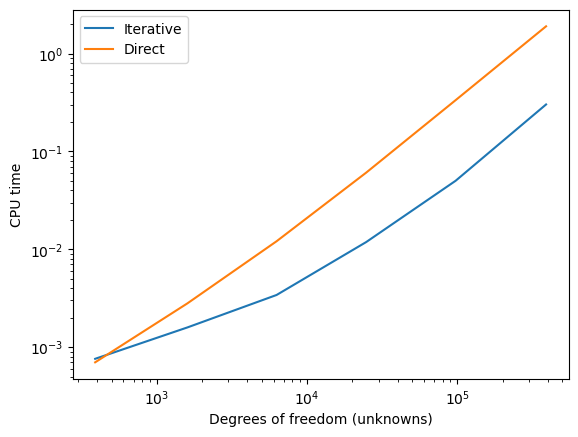

In [11]:
plt.loglog(dofs, tfis, label="Iterative")
plt.loglog(dofs, tfds, label="Direct")
plt.xlabel("Degrees of freedom (unknowns)")
plt.ylabel("CPU time")
plt.legend()
plt.show()

In [12]:
tfds = []
tfis = []
dofs = []
ps = range(1,6)
for p in ps:
    dofd, tfd = solveDirect(0.01, p)
    _, tfi = solveIterative(0.01, p)
    tfis.append(tfi)
    tfds.append(tfd)
    dofs.append(dofd)
    print(f"Dofs: {dofd:6.0f}, Direct: {tfd:1.3e}s, Iterative: {tfi:1.3e}s")

Dofs:   9677, Direct: 1.595e-02s, Iterative: 9.551e-03s


Dofs:  38223, Direct: 9.119e-02s, Iterative: 1.912e-02s


Dofs:  85639, Direct: 3.532e-01s, Iterative: 8.011e-02s


Dofs: 151925, Direct: 8.198e-01s, Iterative: 1.646e-01s


Dofs: 237081, Direct: 1.333e+00s, Iterative: 4.059e-01s


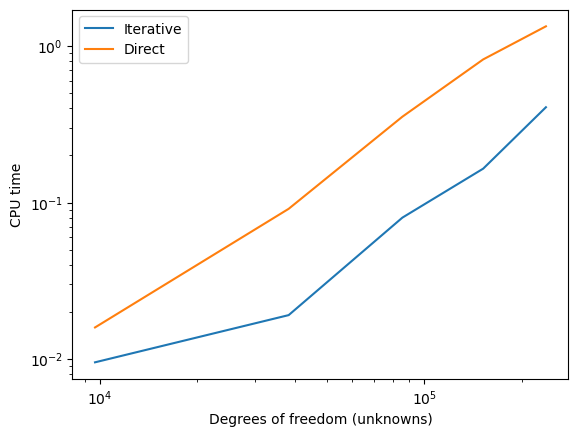

In [13]:
plt.loglog(dofs, tfis, label="Iterative")
plt.loglog(dofs, tfds, label="Direct")
plt.xlabel("Degrees of freedom (unknowns)")
plt.ylabel("CPU time")
plt.legend()
plt.show()

# Motivation problem: CFD

$$ \begin{aligned}-\Delta u + \nabla p = f\\ \mathrm{div}\, u = 0\end{aligned} \Leftrightarrow \begin{aligned}\int \nabla u\cdot \nabla v\,dx + \int p\, \mathrm{div}\, v\,dx && \forall v\in V \\ \int q \,\mathrm{div}\, u \,dx = 0 &&\forall q \in Q \end{aligned} \Leftrightarrow \begin{bmatrix} \mathbf{A} & \mathbf{B}^T \\ \mathbf{B} & \mathbf{0} \end{bmatrix}\begin{bmatrix} \mathbf{U} \\ \mathbf{P} \end{bmatrix} = \begin{bmatrix} \mathbf{F} \\ \mathbf{0} \end{bmatrix}$$

In [14]:
V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
Q = H1(mesh, order=1)
X = V*Q
(u,p),(v,q) = X.TnT()

stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
a = BilinearForm(stokes)
f = LinearForm(v[0]*dx)
gf = GridFunction(X)
gfu, gfp = gf.components

uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
Draw(gfu, mesh, min=0, max=2)
SetVisualization(max=2)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [15]:
# Assembly operations do pending communication
a.Assemble()
f.Assemble()
res = f.vec -a.mat * gf.vec
inv = a.mat.Inverse(freedofs=X.FreeDofs(), inverse="umfpack")
gf.vec.data += inv * res
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [16]:
# Now we compute the nonzeros in the LU factorization
rows,cols,vals = a.mat.COO()
nnzA = len(vals)
A = sp.csr_matrix((vals,(rows,cols))) # NGSolve mat to scipy.sparse
LU = splu(A)
nnzs = LU.L.nnz + LU.U.nnz
print("Number of non-zeros of A:", nnzA)
print("Number of non-zeros of L+U:", nnzs)
print("Ratio of non-zeros:", len(vals)/nnzs)

Number of non-zeros of A: 24024
Number of non-zeros of L+U: 74931
Ratio of non-zeros: 0.320614965768507


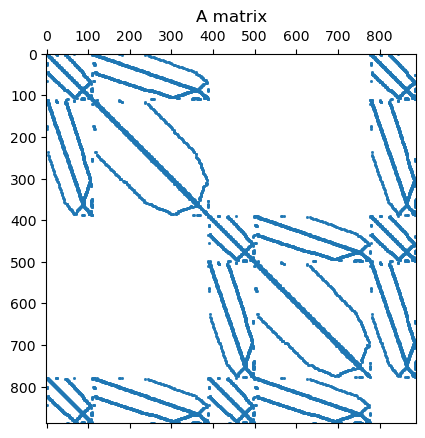

In [17]:
# Spy arrays
plt.spy(A, markersize=1.0)
plt.title("A matrix")
plt.show()

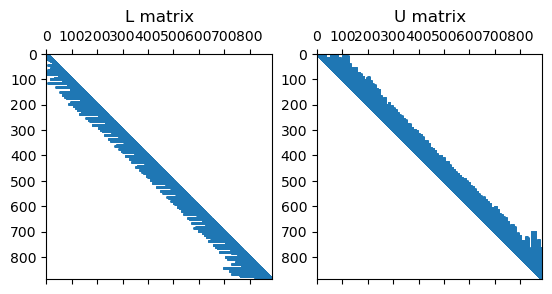

In [18]:
plt.subplot(1,2,1)
plt.spy(LU.L, markersize=1)
plt.title("L matrix")
plt.subplot(1,2,2)
plt.spy(LU.U, markersize=1)
plt.title("U matrix")
plt.show()

In [19]:
def computeNonzeros(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
    a = BilinearForm(stokes).Assemble()
    rows,cols,vals = a.mat.COO()
    nnzA = len(vals)
    
    A = sp.csr_matrix((vals,(rows,cols)))
    LU= splu(A)
    nnzs = LU.L.nnz + LU.U.nnz
    print("Number of non-zeros of A:", nnzA, "(in {:1.3f} Mb)".format(convertToMb(nnzA)))
    print("Number of non-zeros of L+U:", nnzs, "(in {:1.3f} Mb)".format(convertToMb(nnzs)))
    print("Ratio A.nnz / LU.nnz:", nnzA/nnzs)
    return nnzA, nnzs

In [20]:
for h in [0.1, 0.05, 0.01, 0.005]:
    print(f"========= Using h={h:1.3f}")
    nnza, nnzlu = computeNonzeros(h)

========= Using h=0.100
Number of non-zeros of A: 24024 (in 0.192 Mb)
Number of non-zeros of L+U: 74931 (in 0.599 Mb)
Ratio A.nnz / LU.nnz: 0.320614965768507
========= Using h=0.050
Number of non-zeros of A: 103041 (in 0.824 Mb)
Number of non-zeros of L+U: 642311 (in 5.138 Mb)
Ratio A.nnz / LU.nnz: 0.16042228764570435
========= Using h=0.010
Number of non-zeros of A: 2532409 (in 20.259 Mb)
Number of non-zeros of L+U: 57382418 (in 459.059 Mb)
Ratio A.nnz / LU.nnz: 0.04413214166053442
========= Using h=0.005
Number of non-zeros of A: 10091084 (in 80.729 Mb)
Number of non-zeros of L+U: 315893683 (in 2527.149 Mb)
Ratio A.nnz / LU.nnz: 0.0319445577517294


In [21]:
from time import perf_counter
def solveDirect(maxh, p):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = VectorH1(mesh, order=p+1, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=p)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx #-0.1*h*h*grad(p)*grad(q)*dx
    a = BilinearForm(stokes)
    f = LinearForm(v[0]*dx)
    gf = GridFunction(X)
    gfu, gfp = gf.components
    
    uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
    
    gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
    a.Assemble()
    f.Assemble()
    t0 = perf_counter()
    inv = a.mat.Inverse()
    gf.vec.data += inv * f.vec
    tf = perf_counter() - t0
    return X.ndofglobal, tf

def solveIterative(maxh, p):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = VectorH1(mesh, order=p+1, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=p)
    
    u,v = V.TnT()
    p,q = Q.TnT()

    
    a = BilinearForm(InnerProduct(Grad(u),Grad(v))*dx, symmetric=True)
    b = BilinearForm(div(u)*q*dx).Assemble()
    h = specialcf.mesh_size
    c = BilinearForm(-0.1*h*h*grad(p)*grad(q)*dx, symmetric=True).Assemble()
    
    mp = BilinearForm(p*q*dx, symmetric=True)
    f = LinearForm(V).Assemble()
    g = LinearForm(Q).Assemble();
    gfu = GridFunction(V, name="u")
    gfp = GridFunction(Q, name="p")
    uin = CoefficientFunction( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
    gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
    
    Qjacobi = Preconditioner(mp, "local")
    Amg = Preconditioner(a, "bddc")
    a.Assemble()
    mp.Assemble()
    K = BlockMatrix( [ [a.mat, b.mat.T], [b.mat, None] ] )
    C = BlockMatrix( [ [Amg.mat, None], [None, Qjacobi.mat] ] )
    
    rhs = BlockVector ( [f.vec, g.vec] )
    sol = BlockVector( [gfu.vec, gfp.vec] )
    t0 = perf_counter()
    solvers.MinRes (mat=K, pre=C, rhs=rhs, sol=sol, printrates=False, initialize=False, maxsteps=200);
    tf = perf_counter() - t0
    
    return V.ndofglobal+Q.ndofglobal, tf


In [22]:
maxh = 0.01
tfds = []
tfis = []
dofs = []
maxhs = [0.2/2**i for i in range(7)]
for maxh in maxhs:
    # print(f"========= Solving for h={maxh:1.3f}")
    dof, tfd = solveDirect(maxh,1)
    _, tfi = solveIterative(maxh,1)
    tfis.append(tfi)
    tfds.append(tfd)
    dofs.append(dof)
    print(f"Dofs:{dof:6.0f}, Direct: {tfd:1.3e}s, Iterative: {tfi:1.3e}s")

Dofs:   234, Direct: 5.842e-04s, Iterative: 1.864e-03s
Dofs:   888, Direct: 2.030e-03s, Iterative: 4.895e-03s
Dofs:  3627, Direct: 1.014e-02s, Iterative: 1.463e-02s
Dofs: 14154, Direct: 7.702e-02s, Iterative: 5.692e-02s
Dofs: 55778, Direct: 4.505e-01s, Iterative: 2.886e-01s
Dofs:219391, Direct: 2.758e+00s, Iterative: 1.700e+00s
Dofs:876525, Direct: 1.741e+01s, Iterative: 9.139e+00s


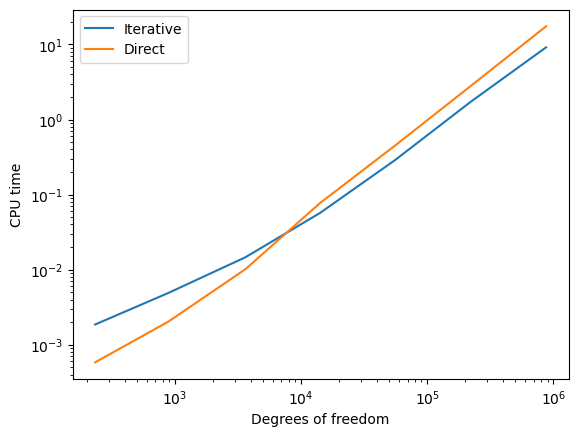

In [23]:
plt.loglog(dofs, tfis, label="Iterative")
plt.loglog(dofs, tfds, label="Direct")
plt.xlabel("Degrees of freedom")
plt.ylabel("CPU time")
plt.legend()
plt.show()

# Wrap up
- Direct methods have very limited scalability (_fill in_)
- Iterative methods overcome this but are more difficult
- We will understand this better by the end of tomorrow